# **NLP project**

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import os

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(palette="GnBu_d")

## Table of Contents

1. [Data Analysis](#part_1)<br>
    0.[ Get_the_data](#part_1_0) <br>
    1.[ Overview](#part_1_1) <br>
    2.[ `overall` variable and labelling](#select_label) <br>
    3.[ Some statistics on variables](#part_1_3) <br>
    4.[ Text variables : `reviewText` and `summary`](#part_1_4) <br>


2. [Tokenization steps](#part_2) <br>

    
3. [Sentiment Analysis Model](#part_3)<br>

    1.[K-means](#part_3_1) <br>
    2.[Logistic Regression](#part_3_2) <br>
    3.[Deep Learning Models](#part_3_3) <br>




<a id='part_1'></a>

# I -  Data Analysis 

<a id='part_1_0'></a>

## 0. Get the data 

In [6]:
from prepare_data import get_data

The function $\textit{get_data ( nb_label )}$ creates a dataframe, converts variables type to the most conveniant form and create labels based on the `overall` variable, which is the actual rate.
If nb_label = 3, the labels are created according to the following rules : 
- If `overall` = 5, then `label` ="positive"
- If `overall` = 4, then `label` ="neutral"
- Else then `label` ="negative"

Please check this [section](#select_label) that explains why we choose such repartition


In [8]:
# We get the dataframe
data = get_data(nb_label=3)

In [33]:
data.head(3)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,label
0,4,True,2016-03-29,AIE8N9U317ZBM,0449819906,{'Format:': ' Kindle Edition'},"Zelmira, Ph.D.",Contains some interesting stitches.,Four Stars,1459209600,NaN,NaT,neutral
1,5,True,2015-08-12,A3ECOW0TWLH9V6,0449819906,{'Format:': ' Paperback'},Dangerous when Cooking,I'm a fairly experienced knitter of the one-co...,My current favorite go-to guide for inspiration,1439337600,18.0,NaT,positive
2,4,True,2015-04-05,A278N8QX9TY2OS,0449819906,{'Format:': ' Paperback'},Just us,Great book but the index is terrible. Had to w...,"lots of great examples, good instructions, col...",1428192000,3.0,NaT,neutral


<a id='part_1_1'></a>

## 1.  Overview

In [47]:
print("We have", data.shape[0], "reviews from", data.reviewerID.nunique() ,"distinct reviewers, and", data.shape[1], "variables.")

We have 494485 reviews from 56210 distinct reviewers, and 13 variables.


Our 13 variables are the following : 
- `overall`: rating from 1 to 5 stars 
- `verified`: true if the review autheur has bought the product 
- `reviewTime` : date of the review 
- `reviewerID`: Id of the reviewer 
- `asin`: reference of the product 
- `style` : version of the product 
- `reviewerName` : reviewer name 
- `reviewText` : review 
- `summary` : "title" of the review
- `vote` : number of person who judged the review pertinent
- `image`: of the product 
- `label`: (creation) 


In [35]:
print(data.dtypes)

overall                    int64
verified                    bool
reviewTime        datetime64[ns]
reviewerID                object
asin                      object
style                     object
reviewerName              object
reviewText                object
summary                   object
unixReviewTime             int64
vote                     float64
image             datetime64[ns]
label                     object
dtype: object


<a id='select_label'></a>

## 2.  `overall` variable and labelling


In [11]:
data.overall.describe()

count    494485.000000
mean          4.566852
std           0.929987
min           1.000000
25%           5.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

The distribution is highly concentrated on the right, with more than 75% of the sample with the value 5 (out of 5). Overall, people seem to be very satisfied with the products.

In [12]:
data.overall.unique()

array([4, 5, 2, 3, 1])

Text(0.5, 1.0, 'Overall distribution')

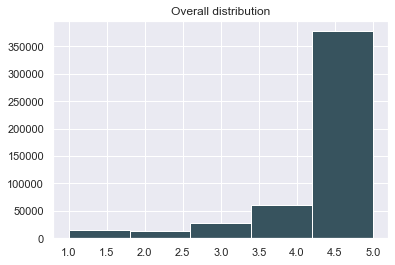

In [13]:
data.overall.hist(bins = 5)
plt.title('Overall distribution')

**Creating the target variable for our future models**

In [48]:
data.label.value_counts(normalize = True)

positive    0.763562
neutral     0.123654
negative    0.112784
Name: label, dtype: float64

**Important note :** We'll have to take subsamples of the positive reviews to reach a balanced dataset and satisfactory accuracy rates.



=> It would be interesting to analyze the relation between the `vote` and `label` variables. Do negative / positive reviews get the highest votes ? 

<a id='part_1_3'></a>

## 3. Some statistics on variables 

Text(0.5, 1.0, 'Period of the reviews ?')

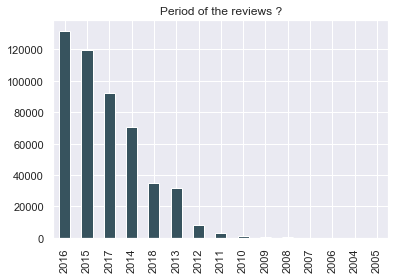

In [18]:
data.reviewTime.dt.year.value_counts(dropna=False).plot(kind='bar')
plt.title("Period of the reviews ?")

Text(0.5, 1.0, 'Is there a seasonality for the reviews ?')

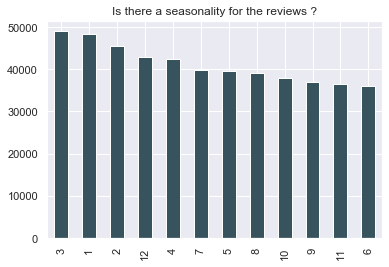

In [19]:
data.reviewTime.dt.month.value_counts(dropna=False).plot(kind='bar')
plt.title('Is there a seasonality for the reviews ?')

People comment throughout the year, there's no specific seasonal trend for client's behavior.

#### A closer look on the `vote` variable : will it be useful for our classification ?

`Vote` variable : on Amazon website, the more votes a comment gets, the more it is useful for the community. One approach of our classification could be to analyse whether reviews with the highest votes are rather positive, neutral, negative ?  

In [21]:
data.vote.describe()

count    71007.000000
mean         7.882800
std         21.572504
min          2.000000
25%          2.000000
50%          3.000000
75%          7.000000
max        903.000000
Name: vote, dtype: float64

In [22]:
data.vote[data.vote > 7].describe()

count    15375.000000
mean        24.584976
std         42.252494
min          8.000000
25%         10.000000
50%         13.000000
75%         23.000000
max        903.000000
Name: vote, dtype: float64

Text(0.5, 1.0, 'Votes distribution')

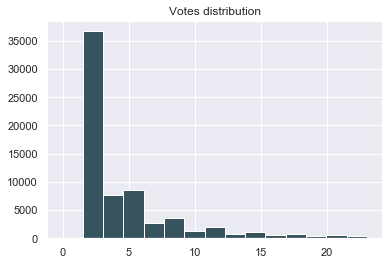

In [23]:
data.vote.hist(range = (0,23), bins = 15)
plt.title('Votes distribution')

**Correlation of the `vote` variable with the `label` of a review.**

In [19]:
data.groupby(['label']).std()

,overall,verified,unixReviewTime,vote
label,,,,
negative,0.83983,0.279139,4.772940e+07,18.506311
neutral,0.00000,0.258071,4.744144e+07,23.335929
positive,0.00000,0.229667,4.480170e+07,22.012503


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a838ec828>,
      dtype=object)

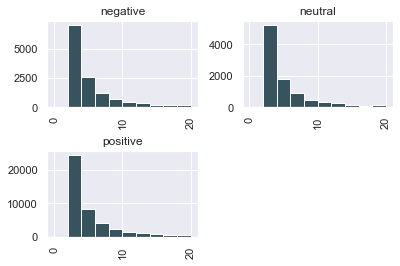

In [20]:
data['vote'].hist(range=(0,20), by=data['label'])

Looking at the distribution of the vote variable for each class of reviews (neutral, positive, negative), it seems that there isn't much difference in terms of behavior: 
- For each label, the average vote is approximately the same. 
- The distribution of the vote variable only differs in proportion, (see positive ratings have 4-5 times the amount of votes compared to the others), but it's only because the data is very unbalanced with an astounding proportion of positive reviews. 

#### How many reviewers ? 

How many reviewers in this dataset ? Are people who give ratings more likely to be more active on the site ? 

In [51]:
data.reviewerID.value_counts(normalize = True)

A13OFOB1394G31    0.000439
ALYZJ7W14YS26     0.000374
A3NDWL56CCM3Q5    0.000372
A2OYDT4I6AK54P    0.000338
AL7KMEKSLCW84     0.000318
                    ...   
A3VUQQR4G6HAZ     0.000008
A8HNE7ZYRCMLR     0.000008
A5AGPUR4P63U7     0.000008
A2T52E9EEEWIER    0.000006
A2NJFRWFN7BLHW    0.000006
Name: reviewerID, Length: 56210, dtype: float64

In [52]:
print('Percentage of unique reviewers', data.reviewerName.nunique()/len(data.reviewerName))

Percentage of unique reviewers 0.09197043388575993


Only 10% of recurrent clients : the dataset is rather diverse.

*There's a slight difference between both variables (`reviewerID` and `reviewerName`) because some different users (by ID) might have the same name.*

<a id='part_1_4'></a>

## 4. Text variables :  `reviewText` and `summary`

#### **First descriptive insights**

In [53]:
print('the % of non-missing values for the reviewText column : ', 
      data.reviewText.count()/len(data.reviewText))
print('the % of non-missing values for the summary column : ', 
      data.summary.count()/len(data.summary))

the % of non-missing values for the reviewText column :  1.0
the % of non-missing values for the summary column :  1.0


There is no missing data for our text columns.

The `summary`variable resumes the comment of the user. 

In [54]:
print('Le %  de summary distincts : ', len(data.summary.unique())/len(data.summary))
print('Le nombre de summary dans le dataset : ', len(data.summary))

Le %  de summary distincts :  0.39604436939442045
Le nombre de summary dans le dataset :  494485


In [55]:
print('Nombre moyen de caractères dans reviewText : ', data.reviewText.drop_duplicates().apply(len).mean())
print('Nombre moyen de caractères dans summary ', data.summary.drop_duplicates().apply(len).mean() )

Nombre moyen de caractères dans reviewText :  195.15210394530507
Nombre moyen de caractères dans summary  32.80974070405131


Text(0.5, 1.0, "Distribution of characters' length for summary variable")

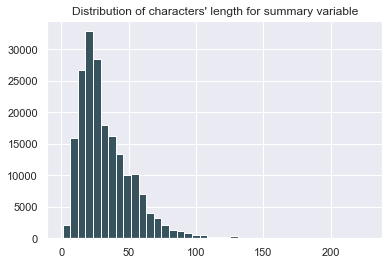

In [56]:
data.summary.drop_duplicates().apply(len).hist(bins = 40)
plt.title("Distribution of characters' length for summary variable")

count    195838.000000
mean         32.809741
std          19.804580
min           1.000000
25%          18.000000
50%          28.000000
75%          43.000000
max         227.000000
Name: summary, dtype: float64
------------------------------------------------
count    352647.000000
mean        195.152104
std         323.523182
min           1.000000
25%          48.000000
50%         108.000000
75%         215.000000
max       19323.000000
Name: reviewText, dtype: float64
------------------------------------------------


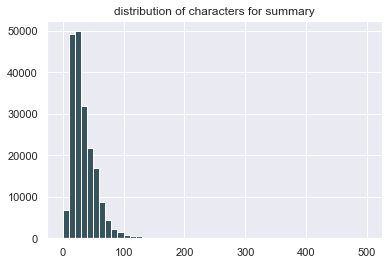

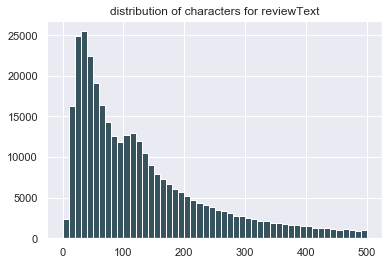

In [60]:
text_var = ('summary', 'reviewText')

for i in text_var: 
    plt.figure()
    plt.title("distribution of characters for {0}".format(i))
    data[i].drop_duplicates().apply(len).hist(bins = 50, range=(0,500))
    plt.plot()
    print(data[i].drop_duplicates().apply(len).describe())
    print('------------------------------------------------')


**Are there any numbers in the characters ?** 

In [63]:
import re

# Regular expression that matches any sequence of numbers:
int_prog = re.compile('[0-9]+')
float_prog = re.compile('[0-9]+\.?[0-9]*')
percent_prog = re.compile('[0-9]+\.?[0-9]*%')
year_prog = re.compile('[12][089][0-9][0-9]') 
df1 = data.drop_duplicates('summary')  

# Calculating number of matches for every abstract
progs = [int_prog, float_prog, percent_prog, year_prog]
nb_types = ['ints', 'floats', 'percents', 'years']
nb_percent_types = [''.join([t, '%']) for t in nb_types]


for prog, nb_type in zip(progs, nb_percent_types):
    df1[nb_type] = df1['summary'].apply(lambda x: 100 *(1 - len(''.join(prog.split(x)))/len(x))).array

df1[nb_percent_types+['summary']].head(3)

,ints%,floats%,percents%,years%,summary
0,0.0,0.0,0.0,0.0,Four Stars
1,0.0,0.0,0.0,0.0,My current favorite go-to guide for inspiration
2,0.0,0.0,0.0,0.0,"lots of great examples, good instructions, col..."


In [64]:
df2 = data.drop_duplicates('reviewText')  

for prog, nb_type in zip(progs, nb_percent_types):
    df2[nb_type] = df2['reviewText'].apply(lambda x: 100 *(1 - len(''.join(prog.split(x)))/len(x))).array

df2[nb_percent_types+['reviewText']].head(3)

,ints%,floats%,percents%,years%,reviewText
0,0.0,0.0,0.0,0.0,Contains some interesting stitches.
1,0.0,0.0,0.0,0.0,I'm a fairly experienced knitter of the one-co...
2,0.0,0.0,0.0,0.0,Great book but the index is terrible. Had to w...


There is no numbers in our text variables so we won't have to add a step to remove them in our cleaning function.

<a id='part_2'></a>

# II - Tokenization steps

In [65]:
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import TreebankWordTokenizer as tok
from nltk.tokenize import word_tokenize
nltk.download('punkt')


[nltk_data] Downloading package punkt to /Users/solene/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### *Counting the frequency of words*

In [44]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.lower()
    all_words = word_tokenize(all_words)

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(30,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.title('the top {0} frequent words in the {1} variable'.format(terms, x.name))
    plt.show()

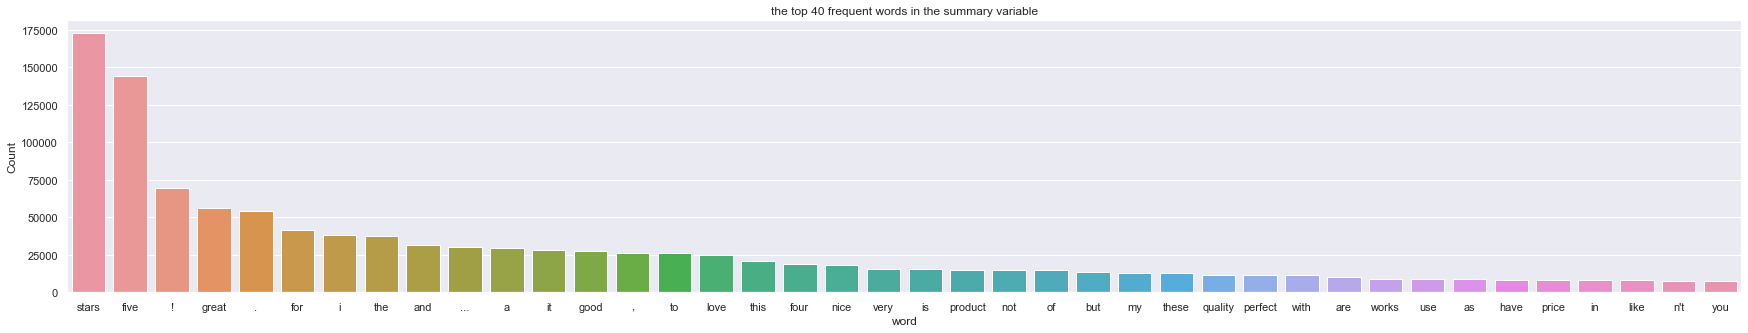

dropping duplicates : 


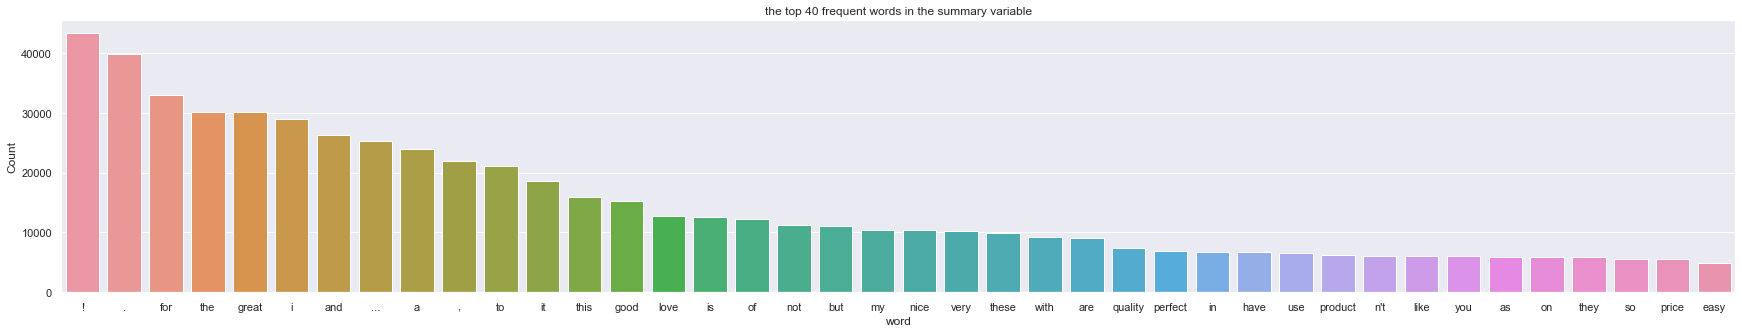

-------------------------------------


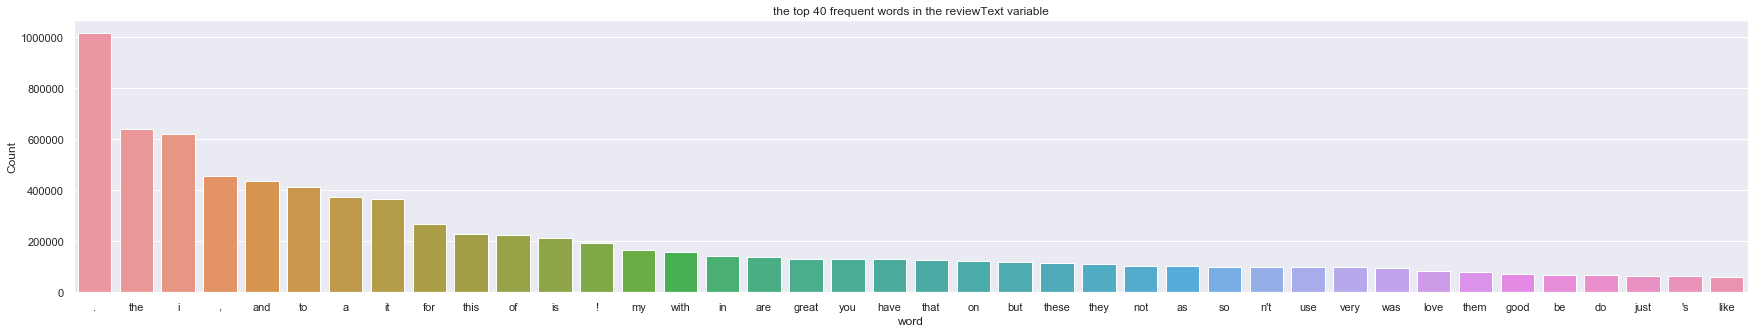

dropping duplicates : 


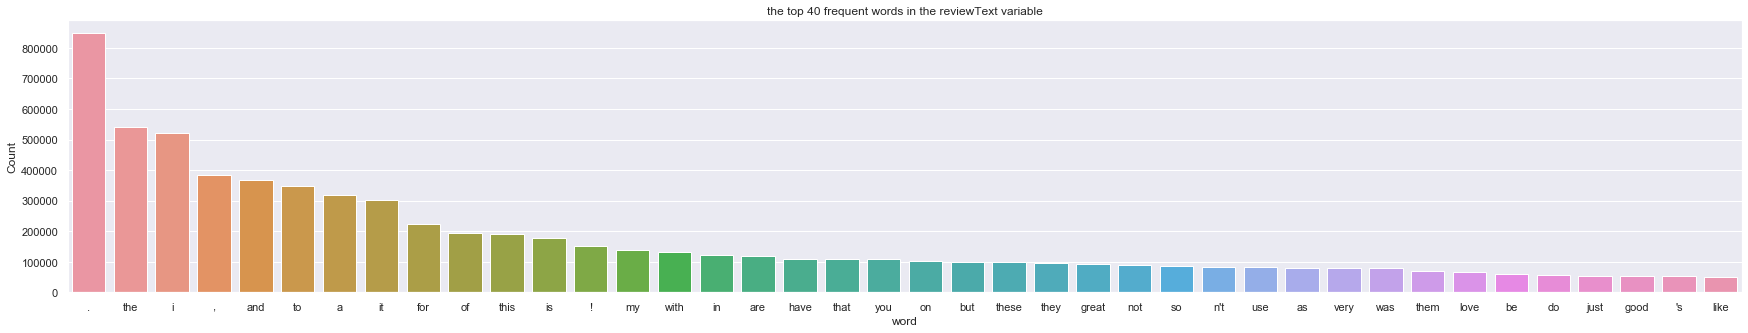

-------------------------------------


In [45]:
for i in text_var:
    freq_words(data[i], terms = 40)
    print('dropping duplicates : ')
    freq_words(data[i].drop_duplicates(), terms = 40)
    print('-------------------------------------')

Conjunctions like `"for"`, tokens like `"a"`, `"it"`, `'m` and some punctuations are not useful at all. For our sentiment analysis model, we should have a clean dataset and remove unuseful tokens.

We also have to lower the characters and do some other preprocessing. 

Some tokens like `"!"` may remain as they testify of a sentiment, either positive or negative. For now, we will drop them.

In [66]:
# Removing stopwords
from string import punctuation

nltk.download('stopwords')

en_stop = set(nltk.corpus.stopwords.words('english'))
to_be_removed = list(en_stop) + list(punctuation)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/solene/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [67]:
#we can change the list of stopwords : add words or reduce it if we want to keep some of them. 
print(to_be_removed)

['when', 'her', 'doesn', 'wouldn', 'both', 'he', 'm', 'we', 'this', 'no', 'a', 'until', "isn't", "you're", 'be', "shan't", "wasn't", 'again', 'that', 'do', 'then', 'before', 'own', 'hasn', 'had', 'further', "should've", 'out', 'not', "don't", 'those', 'through', 'y', 'being', "didn't", 'herself', 'up', 'there', "mustn't", 'have', 'aren', 'why', 'isn', 'himself', 't', 'off', "aren't", 'so', 'myself', 'their', "hasn't", 'between', 'itself', 'our', 'won', 'but', 'some', 'can', 'because', 'from', 'more', 'on', 'for', 'ma', 'ain', 'and', 'down', 'it', 'd', 'as', "you'll", 'hers', 'ourselves', 'where', 'to', 'over', 'i', 'nor', 'an', 'about', "mightn't", 'is', "it's", 's', 'here', 'once', 'were', "that'll", 'did', 'theirs', 'such', 'was', 'weren', 'each', 'should', 'am', "hadn't", 'having', 'its', 'or', 'they', 'the', 'by', 'she', 'hadn', 'him', 'too', 'whom', "haven't", "needn't", 'll', 'my', "weren't", 'under', 'does', 'been', 'with', 'after', 'at', 'just', 'what', 'has', 'in', 'same', 're

In [68]:
# Adding new stopwords 
new_stopwords = ["n't", "'s", '...']
to_be_removed.extend(new_stopwords)

In [49]:
# Function that plots the most frequent words in a clean text variable
# Clean variable: stopwords removed, and tokens starting with " ' " like " 'm " removed too

def freq_words_clean(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.lower()
    all_words = word_tokenize(all_words)
    all_words = [word for word in all_words if not word in to_be_removed]
    all_words = list(filter(lambda x:x[0]!="'", all_words))


    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(30,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.title('Clean version : the top {0} frequent words in the {1} variable'.format(terms, x.name))
    plt.show()

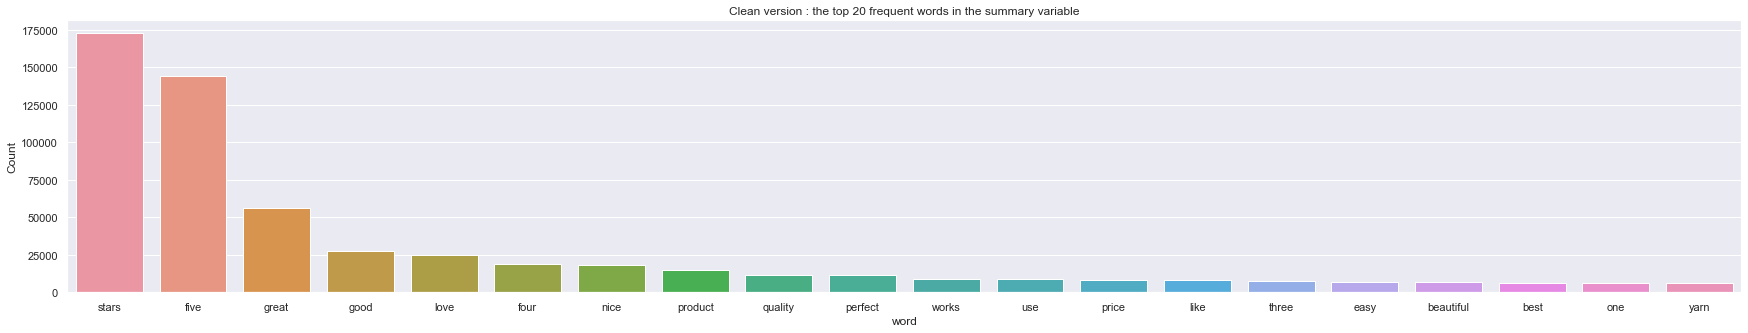

KeyboardInterrupt: 

In [50]:
# What are the top 20 words in our clean text variables ? 
text_var = ('summary', 'reviewText')
for i in text_var: 
    freq_words_clean(data[i], 20)


We can also lemmatize the tokens to boost the efficiency for our model.

<a id='part_3'></a>

# III - Sentiment analysis models

In [1]:
# Clean corpus
def clean_corpus(df):
    words = []
    for i in range(0,len(df)):
        all_words = df[i].lower()
        all_words = word_tokenize(all_words)
        all_words = [word for word in all_words if not word in to_be_removed]
        all_words = list(filter(lambda x:x[0]!="'", all_words))
        all_words = ' '.join([text for text in all_words])
        words.append(all_words)
    return words

In [ ]:
# Cleaning reviews 
data['reviewText'] = clean_corpus(data.reviewText)

In [ ]:
# Cleaning summaries 
data['summary'] = clean_corpus(data.summary)

In [2]:
y = data.label

NameError: name 'data' is not defined

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = TfidfVectorizer()
cv = CountVectorizer()

<a id='part_3_1'></a>

## 1. K-means for a priori vizualisation


In [ ]:
# Using bag-of-words features
X_rev = cv.fit_transform(data.reviewText)
X_sum = cv.fit_transform(data.summary)

We can better tune this bag-of-words vectorization by adding more parameters (`ngram`, `df_min`, etc). However, our goal here is to simply have a visual  unsupervised classification of our two text variables. 

### a) K-means for our `summary` variable

In [10]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20, max_iter=1000, verbose=0).fit(X_sum)
clusters = kmeans.predict(X_sum)

NameError: name 'X_sum' is not defined

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, learning_rate=100.0, early_exaggeration=2., n_iter=250)
X_tsne = tsne.fit_transform(X_sum[0:50000])

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np


mapColors = {0:'lightseagreen', 1:'blueviolet', 2:'tomato'}
#mapSentColors = {'positive':'lightseagreen', 'neutral':'blueviolet', 'negative':'tomato'}
colorsClusters = [mapColors[c] for c in clusters]
#colorsSentiment = [mapSentColors[s] for s in dfTweets.airline_sentiment]

fig = go.Figure(data=go.Scatter(
    x = X_tsne[:, 0],
    y = X_tsne[:, 1],
    hovertext = list(zip(data.summary[0:100000], data.overall[0:100000])),
    mode='markers+text',
    marker=dict(
        size=4,
        color=colorsClusters, # colorsClusters or colorsSentiment
        colorscale='Viridis',
        showscale=True,
    )
))
fig.show()

This a priori vizualisation with k-means is very unsatisfactory: the clustering doesn't seem to be based on positive or negative reviews. 
We can note that : there's a cluster with the `5 stars` reviews in the center of the plan.

> The model may be implemented regarding the lemmas used, the lexical fields...

> For our next models, we'll have to find the optimal word embedding for our models. They may vary regarding the model chosen.



### b) K-means for our `reviewText` variable

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20, max_iter=1000, verbose=0).fit(X_rev[0:10000])
clusters = kmeans.predict(X_rev[0:10000])

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, learning_rate=100.0, early_exaggeration=2., n_iter=250)
X_tsne = tsne.fit_transform(X_rev[0:10000])

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

mapColors = {0:'lightseagreen', 1:'blueviolet', 2:'tomato'}
#mapSentColors = {'positive':'lightseagreen', 'neutral':'blueviolet', 'negative':'tomato'}
colorsClusters = [mapColors[c] for c in clusters]
#colorsSentiment = [mapSentColors[s] for s in dfTweets.airline_sentiment]


fig = go.Figure(data=go.Scatter(
    x = X_tsne[:, 0],
    y = X_tsne[:, 1],
    hovertext = list(zip(data.reviewText[0:10000], data.label[0:10000])),
    mode='markers+text',
    marker=dict(
        size=4,
        color=colorsClusters, # colorsClusters or colorsSentiment
        colorscale='Viridis',
        showscale=True,
    )
))
fig.show()
    

For computational efficiency, we didn't implement the k-means model on the whole dataset for the reviewText variable as it is a very dense input.  Our analysis of the output is the following: 
- The 2% data represented above following the k-means implementation surely doesn't reflect the sentiment analysis model we would like to construct. 
- After some analysis, it seems that this model rather focuses on the lexical field and the length of the reviewtext.
  - for instance, the review data points in purple all seem to talk about `yarns`. 
  - we see again, as in the first representation of the summary variable, a sort of ellipsoide at the top front of the plot. Here, it seems that all the data points of this particular sample of the orange cluster have something in common: very short reviews compared to the rest. 

All in all, this k-means model is very unsatisfactory as the model built doesn't reflect at all the sentiment analysis but seems to be based on other patterns and characteristics of the text variables: lexical field, length of abstracts... 
One reason could be that it is highly unbalanced with more than 75% of positive reviews. 

Our next models will be more helpful for our sentiment classification task. 

<a id='part_3_2'></a>

## 2. Logistic regression model

For high dimensional sparse data, Logistic Regression works well.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = TfidfVectorizer()

### a) Standard Logistic regression 

We will compare the performance of the model :
- using `tf_idf` 
- for the summary and reviewText variables.

#### **Logistic regression on the `summary` variable:**

In [ ]:
X_train, X_devtest, y_train, y_devtest = train_test_split(X_sum, y, test_size=0.4, random_state=42)

**Using `tf_idf` features** : 
words that are unique to a particular document will have higher weights compared to words that are used commonly across documents. 

In [ ]:
# Using tf-idf features 

X_train_tf = vectorizer.fit_transform(X_train)
print(X_train_tf.shape)
X_devtest_tf = vectorizer.transform(X_devtest)
print(X_devtest_tf.shape)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train_tf, y_train)

In [ ]:
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

In [ ]:
lr = grid.best_estimator_
lr.fit(X_train_tf, y_train)

In [ ]:
y_pred = lr.predict(X_devtest_tf)

**Getting some evaluation metrics** (`F1-score`, `accuracy`, `precision`,`recall`...)

In [13]:
def model_eval(y_true, y_pred):
    
    print( classification_report(y_true, y_pred) )
    cm = confusion_matrix(y_devtest, y_pred) 
    labels = ['negative', 'neutral', 'positive']

    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  
    # config plot sizes
    sns.set(font_scale=1.2)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 18}, linewidth=0.5, fmt="")
    score = lr.score(X_devtest_tf, y_devtest)
    all_sample_title = 'Accuracy Score: {0}'.format(score)
    plt.title(all_sample_title, size= 13)
    plt.show()


In [ ]:
model_eval(y_devtest, y_pred)


The data is very unbalanced so the accuracy result is quite biaised. Confusion-matrix is good technique to summarize the performance of a classification algorithm in case of imbalanced classes.



For our next models, now that the optimal logistic regression is trained with GridSearch, we create a function `logistic_regression` that will give us the performance of the model for text variables. 


In [14]:
def logistic_regression(var, target = y, feat = vectorizer):
    X_train, X_devtest, y_train, y_devtest = train_test_split(var, target, test_size=0.4, random_state=42)
    X_train_tf = feat.fit_transform(X_train)
    X_devtest_tf = feat.transform(X_devtest)
    
    lr.fit(X_train_tf, y_train)
    y_pred = lr.predict(X_devtest_tf)
    print('training score = ', lr.score(X_train_tf, y_train))
    print('test score = ', lr.score(X_devtest_tf, y_devtest))
    
    return(model_eval(y_devtest, y_pred))

NameError: name 'y' is not defined

#### **Logistic regression on the `reviewText` variable**

In [ ]:
logistic_regression(data.reviewText)

**Conclusion**: It seems harder for the model to classify the complete reviews than the summary. This is quite surprising : one may have thought it would be easier as there is more content in the `reviewText`. Yet, the reason relies maybe on the fact that it's more noisy and less straight-to-the point compared to the `summary` variable. 

One may note the model generalizes quite well as there isn't a big difference between the train score and the test score.

### b) Let's finetune the Logistic Regression model. 

For sake of efficiency and computational costs, we will:
- focus on a fraction of the dataset 
- use oversampling methods to tackle the issue of unbalanced data

*Note: We will oversample after splitting the data. Indeed, it would otherwise allow the exact same observations to be present in both the test and train sets. Hence the model would simply memorize specific data points and cause overfitting and poor generalization to the test data.*

In [ ]:
# Focus on 10% of the data
data_sample = data.sample(frac= 0.1, replace=False, random_state=1)
#data_sample = data_sample.reset_index() #to avoid problems for the clean_corpus function
#data_sample.head(3)

In [16]:
# Oversampling 

from sklearn.utils import resample

def oversampling_frac(x_train, Y_train, prop = 1):
    'returns a balanced dataset'
    d = {'text':x_train,'label':list(Y_train)}
    df = pd.DataFrame(d)
    
    #separate positive to other classes
    positive = df[df.label == 'positive']
    minority = df[df.label.isin(['negative', 'neutral'])] 
    
    minority_upsampled = resample(minority,
                            replace=True, # sample with replacement
                            n_samples=2*len(positive), # match number in majority class
                            random_state=27) 
    upsampled = pd.concat([positive, minority_upsampled])
    X  = list(upsampled.text)
    Y = upsampled.label
    return X,Y


In [ ]:
data.label.value_counts(normalize=True)

In [ ]:
logreg_finetuned(data_sample.summary, goal = 'description')

The dataset is now better balanced. 

In [17]:
def logreg_finetuned(data, target = data_sample.label, feat = vectorizer, goal = 'model'):
    x_train, X_devtest, Y_train, y_devtest = train_test_split(data, target, test_size=0.4, random_state=42)
    X_train = oversampling_frac(x_train, Y_train)[0]
    y_train = oversampling_frac(x_train, Y_train)[1]
    
    if goal == 'description':
        return oversampling_frac(x_train, Y_train)[1].value_counts(normalize =True)
    else: 
        X_train_tf = feat.fit_transform(X_train)
        X_devtest_tf = feat.transform(X_devtest)
        
        lr.fit(X_train_tf, y_train) # lr = grid best params 
        y_pred = lr.predict(X_devtest_tf)
        print('training score = ', lr.score(X_train_tf, y_train))
        print('test score = ', lr.score(X_devtest_tf, y_devtest))

        #model_eval function:
        labels = ['negative', 'neutral', 'positive']
        df_cm = pd.DataFrame(cm, index=labels, columns=labels)
        sns.set(font_scale=1.2)
        sns.heatmap(df_cm, annot=True, annot_kws={"size": 18}, linewidth=0.5, fmt="")
        score = lr.score(X_devtest_tf, y_devtest)
        all_sample_title = 'Accuracy Score: {0}'.format(score)
        plt.title(all_sample_title, size= 13)
        plt.show()

NameError: name 'data_sample' is not defined

In [ ]:
logreg_finetuned(data_sample.summary)

We notice that there's overfitting with the fine-tuned model. Hence the results are even less satisfactory than with the standard logistic regression. 


A conclusion might be that **we need the real proportion of positive, negative and neutral reviews for the model to perform well.**

Let's see if we can draw the same conclusion for the `reviewText` variable.

In [ ]:
logreg_finetuned(data_sample.reviewText)

Hence we can see that there's still overfitting with the `reviewText` variable. Also, as noticed in the first general logistic regression model (part a),  the accuracy for the test sample is better for the summary `variable` (6 points above).

**We can conclude that:** 
- Logistic Regression models performs better with succinct text variables like titles of a review, summary of a review... The more text there is in a column, the more "noisy" it is and despite our `clean_corpus` function step where stopwords, punctuation are removed, the performance of the model on dense data is very weak.
- With big surprise, the performance of the fine-tuned model is even weaker than the standardized, regular Logistic Regression. Our data was unbalanced with more than 75% of positive data. After oversampling to reach a balanced dataset (approximately 1:1:1 ratio), we notice some **overfitting** effects which were not present before. Moreover, there is not such a gain in accuracy with the fine-tuned model (less than 5 points difference). 



<a id='part_3_3'></a>

## 3 - Deep Learning models 

In this part, words are indexed and represented as 1-hot vectors and we will use embeddings as input in all our Deep NLP models. We will keep 50 as embedding dimension. 

### a. Preparing the data 

In [199]:
def prepare_data(df, text, frac_sample_size) : 
    
    # Convert the label to int
    label_int = [0 if df.overall[i] == 5 else 1 if df.overall[i] == 4 else 2 for i in range(len(df.overall))]
    df['label_int'] = label_int
    
    # Clean the text variable 
    
    if text == "reviewText": 
        df_sample = df.sample(frac=frac_sample_size, replace=False, random_state=1) # Get a sample of the data
       
        X = df_sample["reviewText"]
        y = df_sample["label_int"]
        
        X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.4, random_state=42)
        
        
    else : 
        df_sample = df.sample(frac=frac_sample_size, replace=False, random_state=1) # Get a sample of the data
       
        X = df_sample["summary"]
        y = df_sample["label_int"]
        
        X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=0.4, random_state=42)
        
        
        
    return X_train_raw, X_test_raw, y_train_raw, y_test_raw
        

In [246]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = prepare_data(df = data, text = "reviewText", 
                                                                     frac_sample_size = 0.05)

In [247]:
from keras.preprocessing.text import Tokenizer
MAX_NB_WORDS = 20000

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(X_train_raw)

sequences = tokenizer.texts_to_sequences(X_train_raw)
sequences_test = tokenizer.texts_to_sequences(X_test_raw)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13808 unique tokens.


In [248]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 16.0
max length: 630


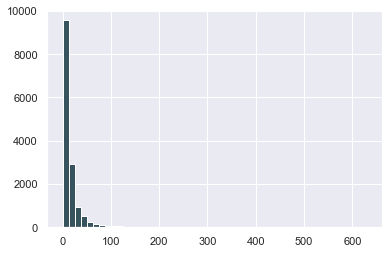

In [249]:
plt.hist([l for l in seq_lens if l < 3000], bins=50);

#### Considering our result, we will use a maximum sequence length of 200 of ReviewText variable and 10 for summary 

In [253]:
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 100

# pad sequences with 0s
X_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train.shape)
print('Shape of data test tensor:', X_test.shape)

Shape of data tensor: (14834, 100)
Shape of data test tensor: (9890, 100)


In [254]:
# We verify we have the correct distinct number of labels
data_sample['label_int'].nunique()

3

In [255]:
# Convert the label 
from keras.utils.np_utils import to_categorical

y_train = to_categorical(np.asarray(y_train_raw))
print('Shape of label tensor:', y_train.shape)

Shape of label tensor: (14834, 3)


### b. Simple CBOW model in Keras 

#### A simple supervised CBOW model in Keras

The following computes a supervised CBoW model which considers the context of words as a Continuous Bag-of-Words. Therefore, we don't take into account the order of the words. 

<img src="images/fasttext.svg" style="width: 500px;" />

- $\textbf{Step 1 }: $ Build an embedding layer mapping each word to a vector representation
- $\textbf{Step 2 }: $ Compute the vector representation of all words in each sequence and average them
- $\textbf{Step 3 }: $ Add a dense layer to output 3 classes (+ softmax)

In [146]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
N_CLASSES = data_sample['label_int'].nunique() #Nb of classes 

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [147]:
model.fit(X_train, y_train, validation_split=0.1, nb_epoch=10, batch_size=128, verbose=2)

Train on 13350 samples, validate on 1484 samples
Epoch 1/10
 - 4s - loss: 0.8734 - acc: 0.7407 - val_loss: 0.7133 - val_acc: 0.7574
Epoch 2/10
 - 3s - loss: 0.6888 - acc: 0.7616 - val_loss: 0.6904 - val_acc: 0.7574
Epoch 3/10
 - 3s - loss: 0.6684 - acc: 0.7616 - val_loss: 0.6735 - val_acc: 0.7574
Epoch 4/10
 - 3s - loss: 0.6445 - acc: 0.7618 - val_loss: 0.6501 - val_acc: 0.7574
Epoch 5/10
 - 3s - loss: 0.6119 - acc: 0.7620 - val_loss: 0.6201 - val_acc: 0.7574
Epoch 6/10
 - 3s - loss: 0.5716 - acc: 0.7627 - val_loss: 0.5878 - val_acc: 0.7574
Epoch 7/10
 - 3s - loss: 0.5294 - acc: 0.7661 - val_loss: 0.5581 - val_acc: 0.7588
Epoch 8/10
 - 3s - loss: 0.4913 - acc: 0.8000 - val_loss: 0.5348 - val_acc: 0.7951
Epoch 9/10
 - 4s - loss: 0.4590 - acc: 0.8345 - val_loss: 0.5177 - val_acc: 0.8147
Epoch 10/10
 - 3s - loss: 0.4320 - acc: 0.8469 - val_loss: 0.5047 - val_acc: 0.8228


In [148]:
## We get the accuracy on the test set
output_test = model.predict(X_test)
test_casses = np.argmax(output_test, axis=-1)
print("test accuracy:", np.mean(test_casses == y_test_raw))

test accuracy: 0.8337714863498483


**Conclusion** : this model is quite efficient (in term of speed and accuracy) on our dataset, although it still takes a lot of time when running the entire dataset

### c. Deeper CBOW model 

This time, we will add depth in our algorithm by adding 1d convolution and 1d maxpooling.

In [165]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

## A 1D convolution with 128 output channels
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)

## A 1D convolution with 64 output channels

#x = Conv1D(64, 5, activation='relu')(x) # for Reviewtest
x = Conv1D(64, 2, activation='relu')(x) # For Summary 


## MaxPool divides the length of the sequence by 5 (or 2 if summary)
# x = MaxPooling1D(5)(x) # For Review
x = MaxPooling1D(2)(x) # For Summary

x = Flatten()(x)

predictions = Dense(N_CLASSES, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


In [156]:
model.fit(X_train, y_train, validation_split=0.1, nb_epoch=10, batch_size=128, verbose=2)

Train on 13350 samples, validate on 1484 samples
Epoch 1/10
 - 6s - loss: 0.4290 - acc: 0.8470 - val_loss: 0.5072 - val_acc: 0.8174
Epoch 2/10
 - 5s - loss: 0.3306 - acc: 0.8799 - val_loss: 0.5296 - val_acc: 0.8201
Epoch 3/10
 - 5s - loss: 0.3072 - acc: 0.8903 - val_loss: 0.5570 - val_acc: 0.8160
Epoch 4/10
 - 5s - loss: 0.2932 - acc: 0.8972 - val_loss: 0.5701 - val_acc: 0.8113
Epoch 5/10
 - 5s - loss: 0.2773 - acc: 0.9006 - val_loss: 0.6109 - val_acc: 0.8154
Epoch 6/10
 - 5s - loss: 0.2653 - acc: 0.9067 - val_loss: 0.6259 - val_acc: 0.8073
Epoch 7/10
 - 5s - loss: 0.2526 - acc: 0.9108 - val_loss: 0.6603 - val_acc: 0.8127
Epoch 8/10
 - 5s - loss: 0.2405 - acc: 0.9156 - val_loss: 0.7050 - val_acc: 0.8053
Epoch 9/10
 - 7s - loss: 0.2303 - acc: 0.9188 - val_loss: 0.7467 - val_acc: 0.8005
Epoch 10/10
 - 5s - loss: 0.2244 - acc: 0.9210 - val_loss: 0.7994 - val_acc: 0.8012


In [157]:
## We get the accuracy on the test set
output_test = model.predict(X_test)
test_casses = np.argmax(output_test, axis=-1)
print("test accuracy:", np.mean(test_casses == y_test_raw))

test accuracy: 0.8151668351870577


**Conclusion:** We can see that increasing depth don't really help us to perform better in our model. 

### d. Adding an LSTM layer 

In this mode, we will add an LSTM layer, before our dense layer with a softmax classification function. 

Indeed, sentiment analysis is very dependant on the word order (eg : in "I don't hate it, we must be careful of the order of the words), so LSTM might improve our performances in our sentiment classification.

In [167]:
from keras.layers import LSTM, Conv1D, MaxPooling1D

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 64 output channels
x = Conv1D(64, 5)(embedded_sequences)
# MaxPool divides the length of the sequence by 5
x = MaxPooling1D(5)(x)

#x = Conv1D(64, 5)(x) # for ReviewText
x = Conv1D(64, 2)(x) # for summary

#x = MaxPooling1D(5)(x) # For ReviewText
x = MaxPooling1D(2)(x) # For Summary 

# LSTM layer with a hidden size of 64
x = LSTM(64)(x)
predictions = Dense(N_CLASSES, activation='softmax')(x)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

# You will get large speedups with these models by using a GPU
# The model might take a lot of time to converge, and even more
# if you add dropout (needed to prevent overfitting)

In [171]:
model.fit(X_train, y_train, validation_split=0.1, nb_epoch=10, batch_size=128, verbose=2)

Train on 13350 samples, validate on 1484 samples
Epoch 1/10
 - 6s - loss: 0.2012 - acc: 0.9277 - val_loss: 0.9378 - val_acc: 0.7972
Epoch 2/10
 - 6s - loss: 0.1994 - acc: 0.9280 - val_loss: 0.9366 - val_acc: 0.7951
Epoch 3/10
 - 6s - loss: 0.1976 - acc: 0.9297 - val_loss: 0.9427 - val_acc: 0.8012
Epoch 4/10
 - 6s - loss: 0.1965 - acc: 0.9288 - val_loss: 0.9640 - val_acc: 0.8059
Epoch 5/10
 - 6s - loss: 0.1983 - acc: 0.9291 - val_loss: 0.9841 - val_acc: 0.7938
Epoch 6/10
 - 6s - loss: 0.1960 - acc: 0.9294 - val_loss: 0.9809 - val_acc: 0.7938
Epoch 7/10
 - 6s - loss: 0.1925 - acc: 0.9303 - val_loss: 1.0204 - val_acc: 0.7918
Epoch 8/10
 - 6s - loss: 0.1910 - acc: 0.9311 - val_loss: 1.0308 - val_acc: 0.7951
Epoch 9/10
 - 6s - loss: 0.1889 - acc: 0.9313 - val_loss: 1.0869 - val_acc: 0.7972
Epoch 10/10
 - 6s - loss: 0.1894 - acc: 0.9316 - val_loss: 1.0345 - val_acc: 0.7972


In [169]:
## We get the accuracy on the test set
output_test = model.predict(X_test)
test_casses = np.argmax(output_test, axis=-1)
print("test accuracy:", np.mean(test_casses == y_test_raw))

test accuracy: 0.8089989888776542


## e. Pre-trained embedding 

### Loading 
 
The file `glove.6B.50d.txt` is an extract of [Glove](http://nlp.stanford.edu/projects/glove/) Vectors, that were trained on english Wikipedia 2014 + Gigaword 5 (6B tokens).

We extracted the `400 000` most frequent words. They have a dimension of `50`

In [204]:
import zipfile
archive = zipfile.ZipFile('glove.6B.zip', 'r')
f = archive.open('glove.6B.50d.txt')
archive.namelist()

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt']

In [205]:
embeddings_index = {}
embeddings_vectors = []

word_idx = 0
for line in f:
    values = line.decode('utf-8').split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = word_idx
    embeddings_vectors.append(vector)
    word_idx = word_idx + 1
f.close()

inv_index = {v: k for k, v in embeddings_index.items()}
print("found %d different words in the file" % word_idx)

found 400000 different words in the file


In [206]:
# We stack all embeddings in a large numpy array
glove_embeddings = np.vstack(embeddings_vectors)
glove_norms = np.linalg.norm(glove_embeddings, axis=-1, keepdims=True)
glove_embeddings_normed = glove_embeddings / glove_norms
print(glove_embeddings.shape)


(400000, 50)


In [207]:
def get_emb(word):
    idx = embeddings_index.get(word)
    if idx is None:
        return None
    else:
        return glove_embeddings[idx]

### Preparing the model

We want to use these pre-trained embeddings for transfer learning. This process is rather similar than transfer learning in image recognition: the features learnt on words might help us bootstrap the learning process, and increase performance if we don't have enough training data.
- We initialize embedding matrix from the model with Glove embeddings:
 - take all words from our vocabulary (`MAX_NB_WORDS = 20000`), and look up their Glove embedding 
 - place the Glove embedding at the corresponding index in the matrix
 - if the word is not in the Glove vocabulary, we only place zeros in the matrix


In [256]:
EMBEDDING_DIM = 50

# prepare embedding matrix
nb_words_in_matrix = 0
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = get_emb(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i-1] = embedding_vector
        nb_words_in_matrix = nb_words_in_matrix + 1
        
print("Added %d words in the embedding matrix" % nb_words_in_matrix)

added 12113 words in the embedding matrix


In [259]:
# We build the layer with the pre-trained embeddings
pretrained_embedding_layer = Embedding(
    MAX_NB_WORDS, EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
)

### Let's run it 

In [262]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)
average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)

# We don't fine-tune embeddings
model.layers[1].trainable=False

model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['acc'])

In [264]:
model.fit(X_train, y_train, validation_split=0.1,nb_epoch=10, batch_size=128, verbose=2)

Train on 13350 samples, validate on 1484 samples
Epoch 1/10
 - 1s - loss: 1.0238 - acc: 0.6867 - val_loss: 0.9427 - val_acc: 0.7574
Epoch 2/10
 - 0s - loss: 0.8836 - acc: 0.7616 - val_loss: 0.8340 - val_acc: 0.7574
Epoch 3/10
 - 0s - loss: 0.7986 - acc: 0.7616 - val_loss: 0.7711 - val_acc: 0.7574
Epoch 4/10
 - 0s - loss: 0.7512 - acc: 0.7616 - val_loss: 0.7374 - val_acc: 0.7574
Epoch 5/10
 - 0s - loss: 0.7264 - acc: 0.7616 - val_loss: 0.7204 - val_acc: 0.7574
Epoch 6/10
 - 0s - loss: 0.7141 - acc: 0.7616 - val_loss: 0.7119 - val_acc: 0.7574
Epoch 7/10
 - 0s - loss: 0.7083 - acc: 0.7616 - val_loss: 0.7082 - val_acc: 0.7574
Epoch 8/10
 - 0s - loss: 0.7057 - acc: 0.7616 - val_loss: 0.7065 - val_acc: 0.7574
Epoch 9/10
 - 0s - loss: 0.7045 - acc: 0.7616 - val_loss: 0.7058 - val_acc: 0.7574
Epoch 10/10
 - 0s - loss: 0.7040 - acc: 0.7616 - val_loss: 0.7055 - val_acc: 0.7574


In [265]:
## We get the accuracy on the test set
output_test = model.predict(X_test)
test_casses = np.argmax(output_test, axis=-1)
print("test accuracy:", np.mean(test_casses == y_test_raw))

test accuracy: 0.7649140546006067


**Conclusion:** We have notive that even if our performances (in term of accuracy) don't increase, we have less overfitting than in our previous models. 